In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Load the data from the csv file
def load_data(path):
    data = pd.read_csv(path)
    return data

In [3]:
df = load_data('D:/NHLPro/data/M2_added_features_all.csv')

In [4]:
# Preprocess the data to get the required features only
def preprocess_data(data):
    # Drop the columns that are not required
    data = data.drop(['Unnamed: 0'], axis=1)
    # Drop period_time 
    data = data.drop(['period_time'], axis=1)
    # Use one hot encoding to convert the categorical variables to numerical
    data = pd.get_dummies(data, columns=['secondary_type','last_event_type'], drop_first=True)

    return data

In [5]:
df = preprocess_data(df)

In [6]:
df.columns

Index(['game_id', 'period', 'coordinates_x', 'coordinates_y', 'shot_distance',
       'shot_angle', 'goal', 'last_event_coordinates_x',
       'last_event_coordinates_y', 'time_from_last_event(s)',
       'distance_from_last_event', 'rebound', 'angle_change', 'speed',
       'secondary_type_Deflected', 'secondary_type_Slap Shot',
       'secondary_type_Snap Shot', 'secondary_type_Tip-In',
       'secondary_type_Wrap-around', 'secondary_type_Wrist Shot',
       'last_event_type_Faceoff', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Penalty',
       'last_event_type_Shot', 'last_event_type_Takeaway'],
      dtype='object')

In [7]:
# Splitting the dataset into the Training set and Test set for grid search CV 5
#preprocess
from sklearn.model_selection import train_test_split
def split_data(data):
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = split_data(df)

In [10]:
print(X_train.shape),print(X_test.shape),print(y_train.shape),print(y_test.shape)

(238493, 27)
(59624, 27)
(238493,)
(59624,)


(None, None, None, None)

In [15]:
from sklearn.ensemble import RandomForestClassifier


def model1(X_train, y_train, X_test, y_test):
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Print the name and gini importance of each feature
    for feature in zip(X_train.columns, clf.feature_importances_):
        print(feature)

    # Plot the feature importance
    plt.figure(figsize=(10,10))
    feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    # Calculate the precision
    from sklearn.metrics import precision_score
    precision = precision_score(y_test, y_pred)
    print('Precision: ', precision)

    # Calculate the recall
    from sklearn.metrics import recall_score
    recall = recall_score(y_test, y_pred)
    print('Recall: ', recall)

    # Calculate the f1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test, y_pred)
    print('F1 score: ', f1)

    # Calculate the AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_test, y_pred)
    print('AUC: ', auc)

    # Calculate the confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

    # Plot the ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()



('game_id', 0.02694174318348553)
('period', 0.01108153642661937)
('coordinates_x', 0.03424225169162561)
('coordinates_y', 0.02994774582401335)
('shot_distance', 0.04052355829200368)
('shot_angle', 0.0346590370724015)
('goal', 0.0030062351580555403)
('last_event_coordinates_x', 0.13753218328776085)
('last_event_coordinates_y', 0.12534913229211295)
('time_from_last_event(s)', 0.03353456850013247)
('distance_from_last_event', 0.07093614340873682)
('rebound', 0.013734467106103784)
('angle_change', 0.007465162534249041)
('speed', 0.05188076812179752)
('secondary_type_Deflected', 0.0009076998394104031)
('secondary_type_Slap Shot', 0.002688587203368689)
('secondary_type_Snap Shot', 0.0029976320832118437)
('secondary_type_Tip-In', 0.0016165622048825439)
('secondary_type_Wrap-around', 0.0006034054800691541)
('secondary_type_Wrist Shot', 0.00435345572786849)
('last_event_type_Faceoff', 0.05294663335342973)
('last_event_type_Giveaway', 0.12445724617035142)
('last_event_type_Goal', 0.0007707979060

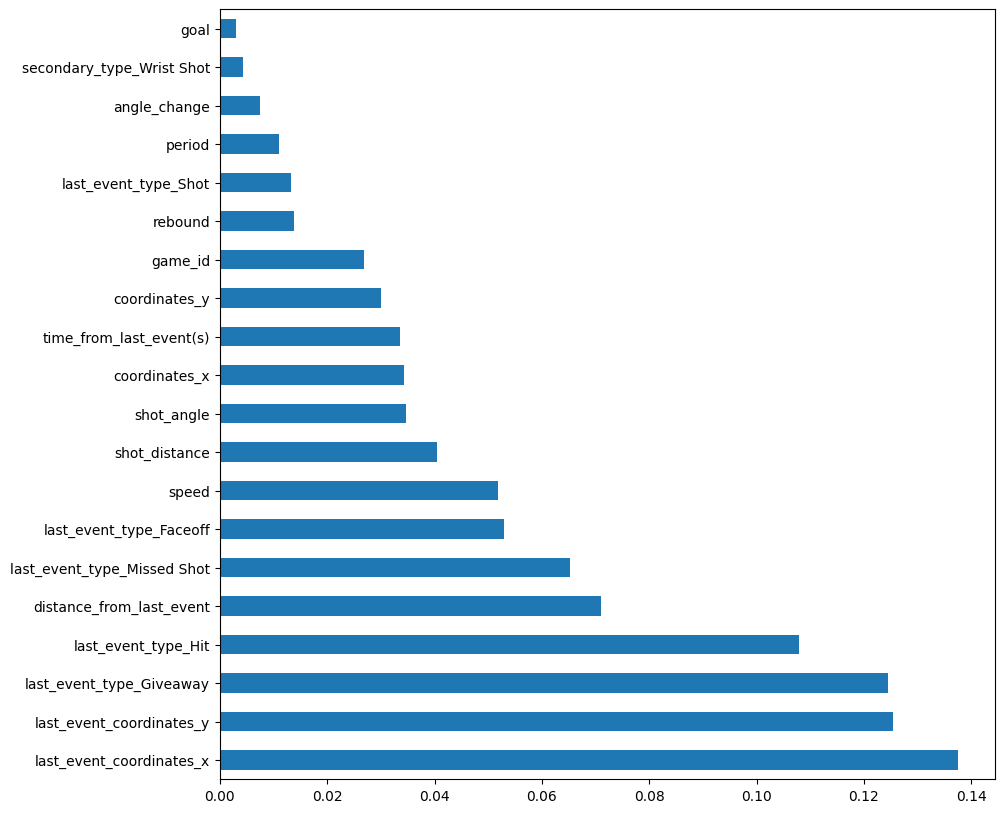

Accuracy:  0.9794545820474977
Precision:  0.9009687836383208
Recall:  0.7961950059453032
F1 score:  0.8453478096199974
AUC:  0.8947773420170227
[[55051   368]
 [  857  3348]]


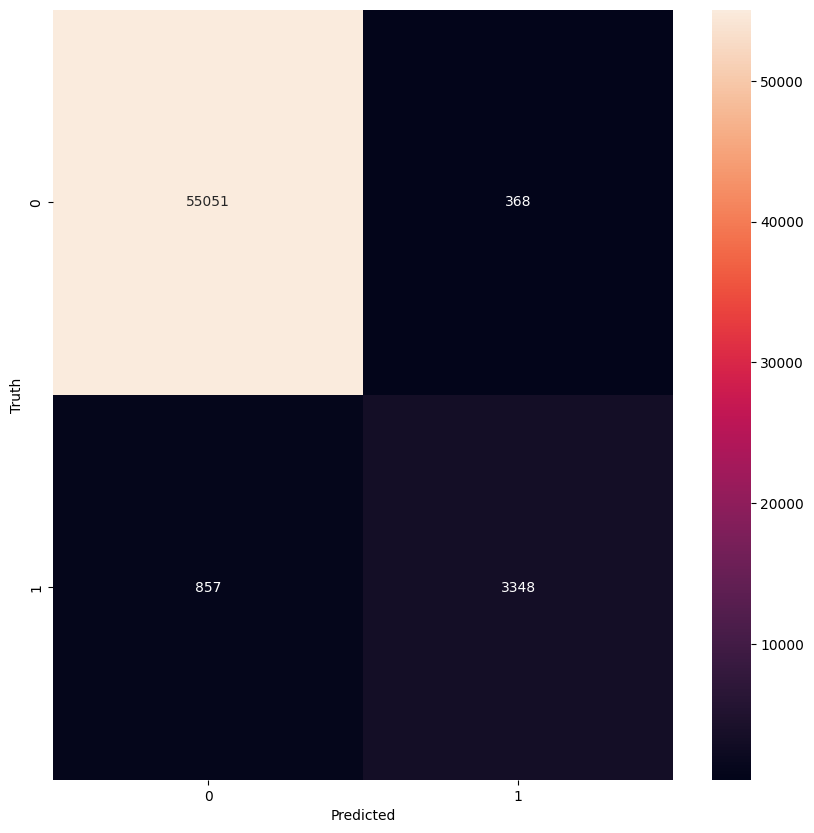

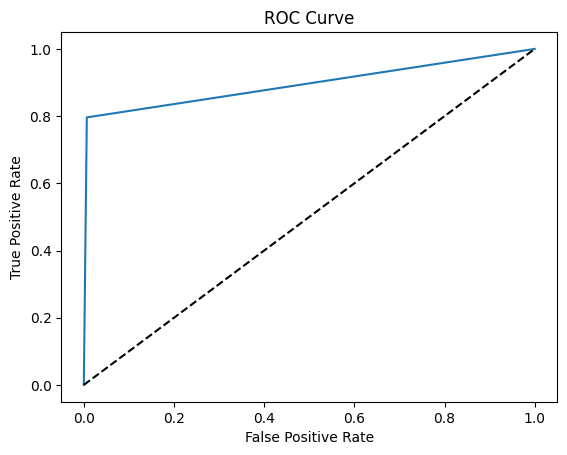

In [16]:
model1(X_train, y_train, X_test, y_test)

In [17]:
# Hyper parameter tuning for random forest classifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def model1_modified(X_train,y_train,X_test,y_test):
    # Create a random forest classifier
    clf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=10, max_features='auto')

    # Create a pipeline
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict the test set
    y_pred = pipe.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    #Classification report
    report = classification_report(y_test, y_pred)
    print(report)

    return pipe, accuracy, cm, report

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


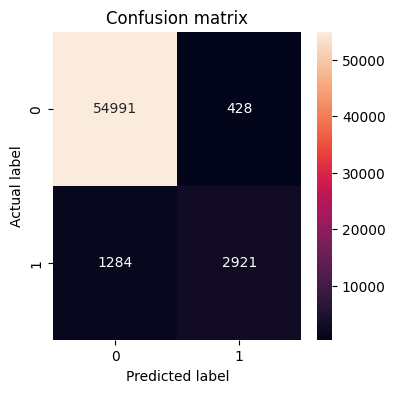

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     55419
           1       0.87      0.69      0.77      4205

    accuracy                           0.97     59624
   macro avg       0.92      0.84      0.88     59624
weighted avg       0.97      0.97      0.97     59624



In [18]:
xgb2,accuracy2,matrix2,report2 = model1_modified(X_train,y_train,X_test,y_test)

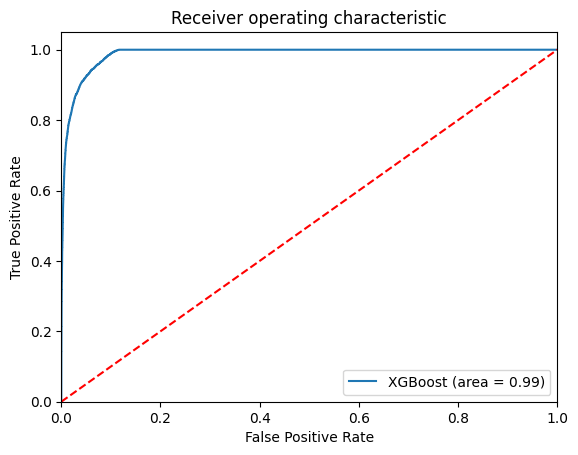

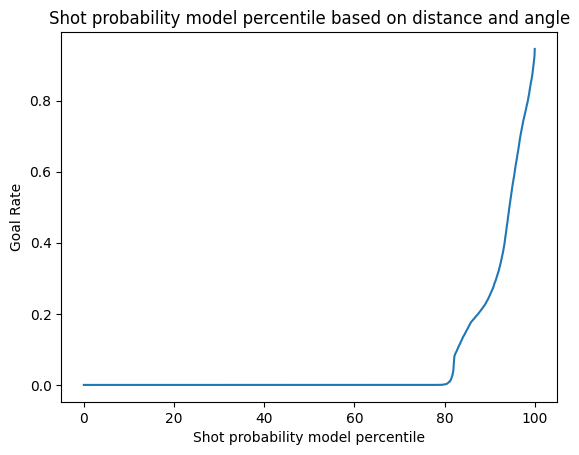

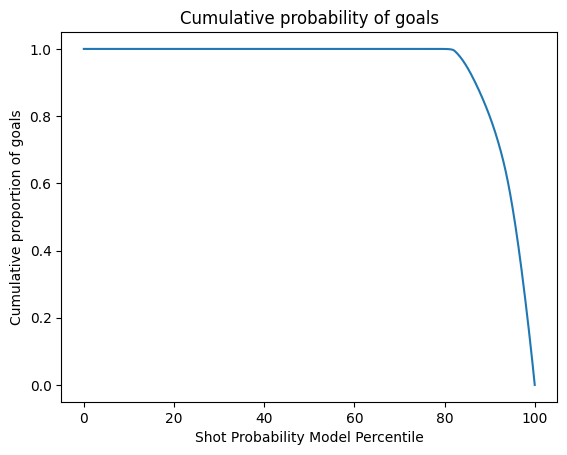

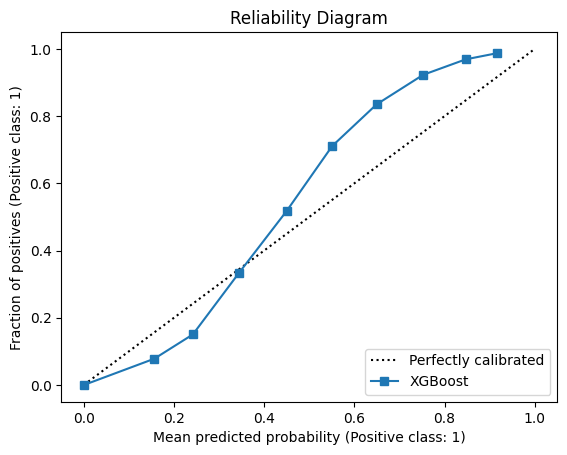

In [20]:
# Import the AdvancedModels.py file
from AdvancedModels_XGBoost1 import *

# Plot roc curve using function from AdvancedModels.py
# The functions contain the model name as XGBoost and hence it displays as XGBoost 
plot_roc_curve(xgb2, X_test, y_test)
shot_probability(xgb2, X_test)
cumulative_probability(xgb2, X_test)
calibration_plot(xgb2, X_test, y_test)

##### MLP

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


def model2(X_train, y_train, X_test, y_test):
    # Create a MLP classifier
    clf = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    
    return clf, accuracy


In [22]:
mlp, accuracy = model2(X_train, y_train, X_test, y_test)


Accuracy:  0.9294747081712063


In [29]:
# Hyperparameter tuning and regularization for MLP classifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

def model2_modified(X_train, y_train, X_test, y_test):
    # Create a MLP classifier
    clf = MLPClassifier(random_state=0, max_iter=1000, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')

    # Create a pipeline
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

    # Fit the model
    pipe.fit(X_train, y_train)

    # Predict the test set
    y_pred = pipe.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix
    # Display confusion matrix as a plot
    # TypeError: confusion_matrix() missing 1 required positional argument: 'y_val'
    # Solution to this error is to pass y_test and y_pred as parameters
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(4,4))
    # sns.heatmap(cm, annot=True, fmt='d')
    # plt.title('Confusion matrix')
    # plt.ylabel('Actual label')
    # plt.xlabel('Predicted label')
    # plt.show()
    

    #Classification report
    report = classification_report(y_test, y_pred)

    return pipe, accuracy, report



In [30]:
mlp2, accuracy2,report2 = model2_modified(X_train, y_train, X_test, y_test)

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

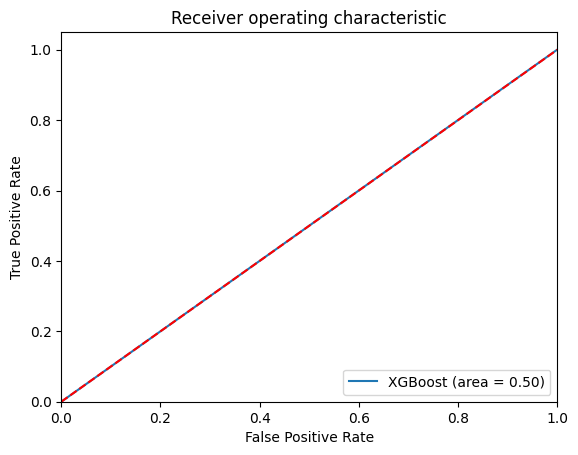

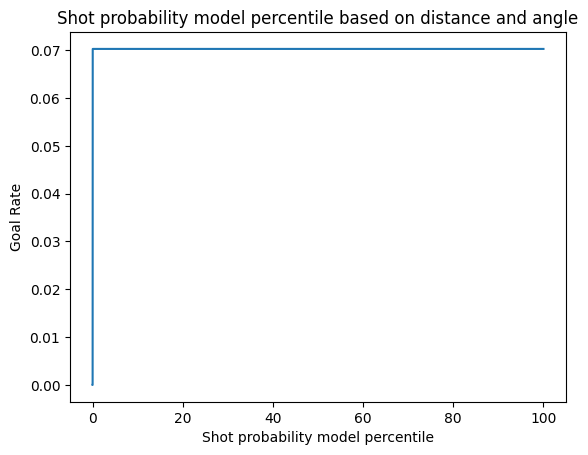

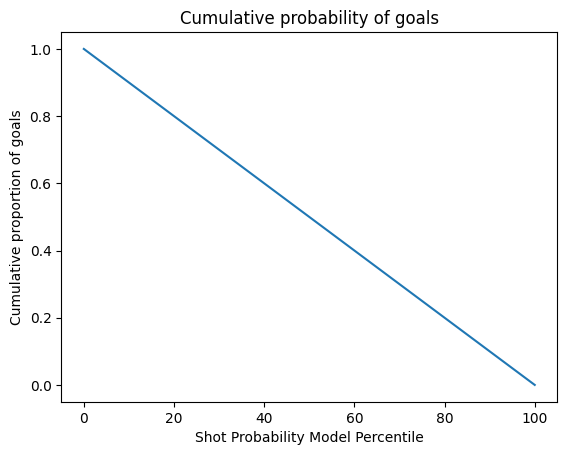

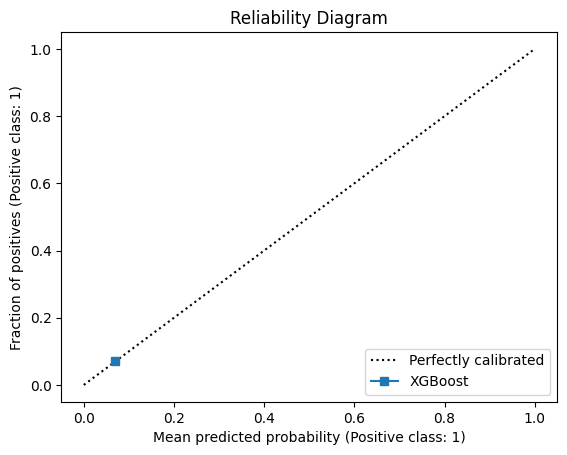

In [31]:
# Plot roc curve using function from AdvancedModels.py
plot_roc_curve(mlp2, X_test, y_test)
shot_probability(mlp2, X_test)
cumulative_probability(mlp2, X_test)
calibration_plot(mlp2, X_test, y_test)


In [32]:
# Hyper tune the parameters for MLP classifier using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
# Import pipeline
from sklearn.pipeline import Pipeline
#Import PCA
from sklearn.decomposition import PCA

def model2_modified2(X_train, y_train, X_test, y_test):

    # Create a MLP classifier
    clf = MLPClassifier(random_state=0, max_iter=10, hidden_layer_sizes=(100,100,100), activation='relu', solver='adam')

    # Create a pipeline
    pipe = Pipeline(steps=[('pca', PCA()), ('clf', clf)])

    # Create a dictionary of hyperparameters
    param_grid = {
        'clf__hidden_layer_sizes': [ (100,100), (100,)],
        'clf__activation': ['relu', 'tanh', 'logistic'],
        'clf__solver': ['adam', 'sgd', 'lbfgs'],
        'clf__alpha': [0.0001, 0.05],
        'clf__learning_rate': ['constant','adaptive'],
    }

    # Create a randomized search cross validation
    random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=3, cv=5, random_state=0)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Predict the test set
    y_pred = random_search.predict(X_test)

    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Confusion matrix
    # Display confusion matrix as a plot
    # TypeError: confusion_matrix() missing 1 required positional argument: 'y_val'
    # Solution to this error is to pass y_test and y_pred as parameters
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(4,4))
    # sns.heatmap(cm, annot=True, fmt='d')
    # plt.title('Confusion matrix')
    # plt.ylabel('Actual label')
    # plt.xlabel('Predicted label')
    # plt.show()


    #Classification report
    report = classification_report(y_test, y_pred)

    return random_search, accuracy, report




In [33]:
model2_1, accuracy2_1, report2_1 = model2_modified2(X_train, y_train, X_test, y_test)

C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pupne\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

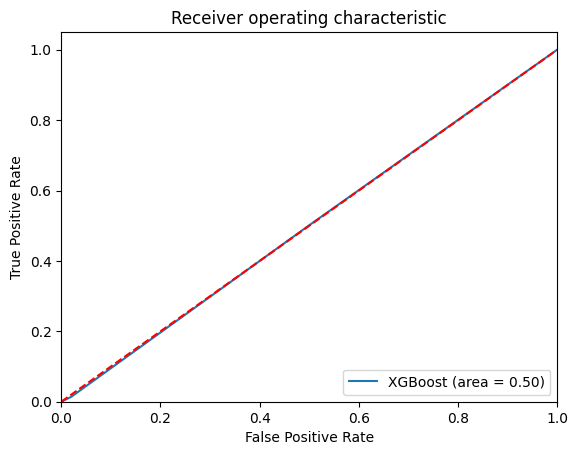

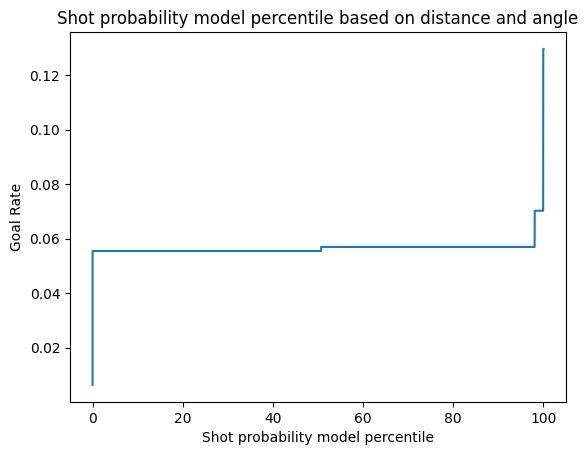

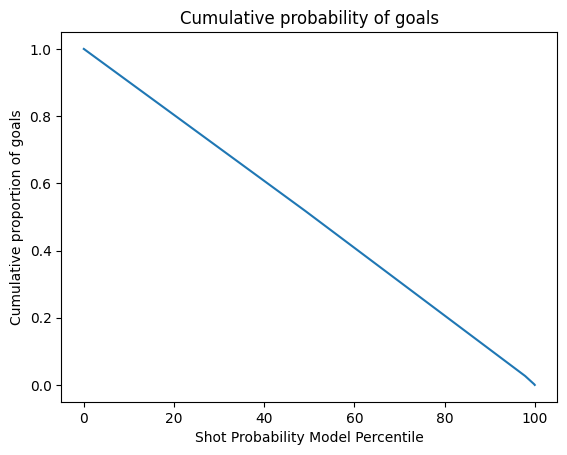

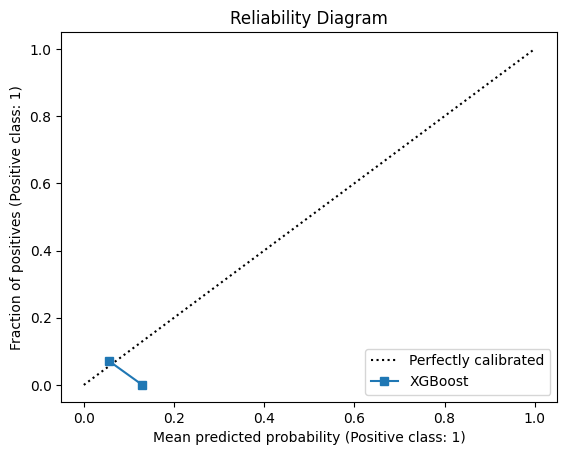

In [34]:
plot_roc_curve(model2_1, X_test, y_test)
shot_probability(model2_1, X_test)
cumulative_probability(model2_1, X_test)
calibration_plot(model2_1, X_test, y_test)


In [20]:
# # Using the best estimator to train the model
# best_estimator = random_search.best_estimator_

# # Predict the test set
# y_pred = best_estimator.predict(X_test)